In [1]:
from datetime import date
from glob import glob
import json
import os
from pathlib import Path
import pickle
import sys
import time

from matplotlib.colorbar import Colorbar
from matplotlib.gridspec import GridSpec
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import mplcursors
import numpy as np
import pandas as pd
from scipy import interpolate, signal, stats, fftpack, ndimage

In [2]:
sys.path.append(r'C:\Users\lesliec\code')

In [3]:
from tbd_eeg.tbd_eeg.data_analysis.eegutils import EEGexp
from tbd_eeg.tbd_eeg.data_analysis.Utilities.utilities import get_evoked_traces, get_events_wdict, find_nearest_ind

In [4]:
%matplotlib widget

# Load experimental subjects

In [5]:
subject_csv = Path(r"C:\Users\lesliec\OneDrive - Allen Institute\analysis\GAT1-KO_analyses\GAT1_control_NPephys_subjects.csv")
all_subexp = pd.read_csv(subject_csv, converters={'mouse': str})
all_subexp.head()

,genotype,mouse,experiment,drug,inj_time,sweep_states,bad_chs,CCFres,NPX_analysis,EEG_analysis,skull_screws,NPX_ref,EEG_ref,shared_ref_gnd,data_loc,notes
0,GAT1-KO,645606,EEGNPXspont_estim_2022-12-20_12-26-39,none,0,awake,none,25,True,True,2.0,Neuropixels tip reference electrode,NaN,NaN,E:\GAT1_EEG_pilot\mouse645606\EEGNPXspont_esti...,100um offset stim electrode
1,GAT1-KO,644565,EEGNPXspont_estim_2022-12-22_10-36-08,none,0,awake,none,25,True,True,2.0,Neuropixels tip reference electrode,NaN,NaN,E:\GAT1_EEG_pilot\mouse644565\EEGNPXspont_esti...,"100um offset stim electrode, probeB LFP estim ..."
2,GAT1-KO,672785,EEGNPXspont_estim_2023-07-05_12-39-59,none,0,awake,all,25,True,False,2.0,Neuropixels tip reference electrode,"stainless steel skull screw, left CB","separate ref, shared gnd",E:\GAT1_EEG_pilot\mouse672785\EEGNPXspont_esti...,EEG has low amplitude signals and all chs look...
3,GAT1-KO,672789,EEGNPXspont_estim_2023-07-13_13-28-01,none,0,awake,none,25,True,True,2.0,"stainless steel skull screw, right CB","stainless steel skull screw, left CB","separate ref, shared gnd",E:\GAT1_EEG_pilot\mouse672789\EEGNPXspont_esti...,NaN
4,wildtype,654181,estim_vis_2022-11-22_09-42-58,isoflurane,0,"awake,isoflurane","7,8,11,13",25,True,True,NaN,NaN,NaN,NaN,F:\psi_exp\mouse654181\estim_vis_2022-11-22_09...,good control mouse with RT units


# Test one session

In [6]:
choose_sub = 0
exprow = all_subexp.iloc[choose_sub]
exp = EEGexp(exprow.data_loc, preprocess=False, make_stim_csv=False)

Experiment type: electrical stimulation


In [7]:
if exprow.EEG_analysis:
    print('Yes, this experiment has good EEG data.')
else:
    print('This experiment does NOT have good EEG data, skip it.')

Yes, this experiment has good EEG data.


In [8]:
plotsavedir = os.path.join(r'C:\Users\lesliec\OneDrive - Allen Institute\analysis\GAT1-KO_analyses', 'mouse' + exp.mouse)
if not os.path.exists(plotsavedir):
    os.mkdir(plotsavedir)

exp_tag = exp.experiment_folder[exp.experiment_folder.find('mouse')+12:exp.experiment_folder.find(str(exp.date.year))-1]
print(exp_tag)

EEGNPXspont_estim


In [9]:
stim_elec_file = os.path.join(exp.data_folder, r'stim_elec_location.json')
if os.path.exists(stim_elec_file):
    with open(stim_elec_file) as elec_file:
        stim_elec_data = json.load(elec_file)
    print(stim_elec_data)
else:
    print('Stim electrode location file not found.')

{'surface': {'area': 'MOs1', 'ccf_coords': [148, 61, 150]}, 'tip': {'area': 'ccg', 'ccf_coords': [176, 116, 163]}}


In [10]:
stim_elec_data['tip']['area']

'ccg'

## Load experimental data

### Load stim log

In [11]:
if exp.stimulus_log_file:
    stim_log = pd.read_csv(exp.stimulus_log_file).astype({'parameter': str})
else:
    print('No stim log found.')

In [12]:
stim_log.head()

,stim_type,parameter,duration,onset,offset,sweep,mean_speed,resting_trial,SWD,good
0,biphasic,50,0.0004,3004.42943,3004.42983,0,10.281199,False,True,True
1,biphasic,50,0.0004,3025.43502,3025.43542,0,5.057074,False,True,True
2,biphasic,50,0.0004,3044.45591,3044.45631,0,0.000000,True,True,True
3,biphasic,50,0.0004,3064.48025,3064.48065,0,0.432813,False,True,True
4,biphasic,50,0.0004,3085.27708,3085.27748,0,4.700194,False,False,True


### Load manual annotation of event in SWD

In [13]:
stimSWDfile = os.path.join(exp.data_folder, r'EP_in_SWD_LFP.npy')
stimSWDboolfile = os.path.join(exp.data_folder, r'EP_in_SWD_LFP_TF.npy')
# stimSWDbool2file = os.path.join(exp.data_folder, r'EP_in_SWD_LFP_TF2.npy')
if os.path.exists(stimSWDfile):
    stim_in_SWD = np.load(stimSWDfile)
    stim_in_SWDtf = np.load(stimSWDboolfile).astype(bool)
    # stim_in_SWDtf2 = np.load(stimSWDbool2file).astype(bool)
    print(stim_in_SWD[:10])
    # stim_log['manualSWD'] = stim_in_SWD
else:
    print('Session has no EP_in_SWD file.')

['f' 'f' 'f' 'f' 'f' 'f' 't' 't' 'f' 't']


In [14]:
print(stim_in_SWD[:20])
print(stim_in_SWDtf[:20])
# print(stim_in_SWDtf2[:20])

['f' 'f' 'f' 'f' 'f' 'f' 't' 't' 'f' 't' 't' 'f' 'f' 't' 'a' 'f' 'f' 't'
 't' 'f']
[False False False False False False  True  True False  True  True False
 False  True False False False  True  True False]


In [15]:
print(np.sum(stim_in_SWDtf))
# print(np.sum(stim_in_SWDtf2))

33


### Load SWD events

In [16]:
auto_annot_file = os.path.join(exp.data_folder, r'autoSWDs_v1.pkl')
if os.path.exists(auto_annot_file):
    print('Whoope there it is.')
    autoSWD_df = pd.read_pickle(auto_annot_file)
else:
    print('Session has no SWD file.')
    autoSWD_df = None

Whoope there it is.


In [17]:
autoSWD_df.head()

,onset,offset,duration,spike_count,SWD_spike_times
0,62.907683,65.411671,2.503988,19,"[62.90768339318237, 63.042882738287446, 63.158..."
1,66.102868,68.190058,2.087190,16,"[66.1028679159616, 66.20286743157186, 66.30486..."
2,73.099234,74.083229,0.983995,9,"[73.09923402611828, 73.21323347391399, 73.3440..."
3,78.675207,81.261194,2.585987,17,"[78.67520701654675, 78.80320639652788, 78.9444..."
4,83.168785,84.357979,1.189194,10,"[83.16878525000968, 83.2935846454913, 83.42478..."


## Load EEG

In [18]:
eeg_data, eeg_ts = exp.load_eegdata()
eeg_data = eeg_data * 1E-3 # convert to mV
eeg_chs = np.arange(0, eeg_data.shape[1])

bad_chs = []
GOOD_CHS = np.array([x for x in eeg_chs if x not in bad_chs])

In [19]:
bpb, bpa = signal.butter(3, np.array([0.5, 50])/(exp.ephys_params['EEG']['sample_rate']/2), btype='bandpass')
filt_data = signal.filtfilt(bpb, bpa, eeg_data, axis=0)

#### Get event traces from raw EEG

In [20]:
event_window = [-2.0, 2.0]
plot_events = stim_log[stim_log['stim_type'] == 'biphasic']
raw_event_EEG, event_ts = get_evoked_traces(
    eeg_data, eeg_ts, plot_events.onset.values, -event_window[0], event_window[1], exp.ephys_params['EEG']['sample_rate']
)
print(raw_event_EEG.shape)

(10000, 30, 60)


Text(0.5, 1.0, 'All stim trials, ch 13')

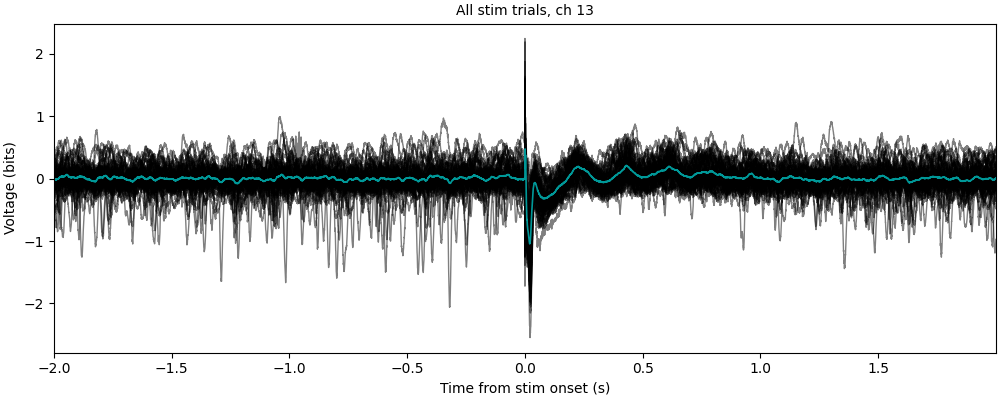

In [21]:
plot_ch = 13
fig, ax = plt.subplots(figsize=(10,4), constrained_layout=True)
ax.plot(event_ts, raw_event_EEG[:, plot_ch, :], color='k', linewidth=1.0, alpha=0.5)
ax.plot(event_ts, np.mean(raw_event_EEG[:, plot_ch, :], axis=1), color='c', linewidth=1.2, alpha=0.8)
ax.set_xlim([event_ts[0], event_ts[-1]])
ax.set_xlabel('Time from stim onset (s)')
ax.set_ylabel('Voltage (bits)')
ax.set_title('All stim trials, ch {:d}'.format(plot_ch))

### Rank amplitude for all EEG chs

In [22]:
event_window = [-2.0, 2.0]
plot_events = stim_log[stim_log['stim_type'] == 'biphasic']
filt_event_EEG, event_ts = get_evoked_traces(
    filt_data, eeg_ts, plot_events.onset.values, -event_window[0], event_window[1], exp.ephys_params['EEG']['sample_rate']
)
print(filt_event_EEG.shape)

(10000, 30, 60)


Get the mean amplitude in a baseline window and the response window

In [23]:
BaselineWindow = [-0.5, -0.01]
ResponseWindow = [0.005, 0.1]

In [24]:
baselineinds = np.squeeze(np.argwhere((event_ts >= BaselineWindow[0]) & (event_ts <= BaselineWindow[1])))
responseinds = np.squeeze(np.argwhere((event_ts >= ResponseWindow[0]) & (event_ts <= ResponseWindow[1])))

Pw_Baseline = np.mean(np.abs(filt_event_EEG[baselineinds, :, :]), axis=0)
Pw_Response = np.mean(np.abs(filt_event_EEG[responseinds, :, :]), axis=0)
print(Pw_Response.shape)

(30, 60)


### Get the mean rank value for all SWD EPs

All trials

In [33]:
plot_ch = 12
ch_ranked = np.argsort(Pw_Response[plot_ch, :])
print(ch_ranked)
print(len(ch_ranked))

[19 20 15  0 11 16  2 10  4  8  5  1 12 49 50  6 42  3 48 58 41 37 17 53
 59  7 57  9 35 46 52 55 18 31 25 54 34 32 23 21 26 14 24 13 47 27 28 36
 22 51 40 44 33 43 45 39 56 30 38 29]
60


In [34]:
trial_ranks = np.empty_like(ch_ranked)
trial_ranks[ch_ranked] = np.arange(len(ch_ranked)) + 1
rankings = trial_ranks / np.max(trial_ranks)
print(rankings)

[0.06666667 0.2        0.11666667 0.3        0.15       0.18333333
 0.26666667 0.43333333 0.16666667 0.46666667 0.13333333 0.08333333
 0.21666667 0.73333333 0.7        0.05       0.1        0.38333333
 0.55       0.01666667 0.03333333 0.66666667 0.81666667 0.65
 0.71666667 0.58333333 0.68333333 0.76666667 0.78333333 1.
 0.96666667 0.56666667 0.63333333 0.88333333 0.61666667 0.48333333
 0.8        0.36666667 0.98333333 0.93333333 0.85       0.35
 0.28333333 0.9        0.86666667 0.91666667 0.5        0.75
 0.31666667 0.23333333 0.25       0.83333333 0.51666667 0.4
 0.6        0.53333333 0.95       0.45       0.33333333 0.41666667]


In [35]:
SWDmeanrank = np.mean(rankings[stim_in_SWDtf])

Compare to randomly shuffled trials

In [36]:
ruff = np.arange(len(ch_ranked)) + 1
ruff_rankings = ruff / np.max(ruff)
rand_mean_rank = []
for i in range (100):
    np.random.shuffle(ruff_rankings)
    rand_mean_rank.append(np.mean(ruff_rankings[stim_in_SWDtf]))
rand_mean_rank = np.array(rand_mean_rank)

Text(0.5, 1.0, 'All trials')

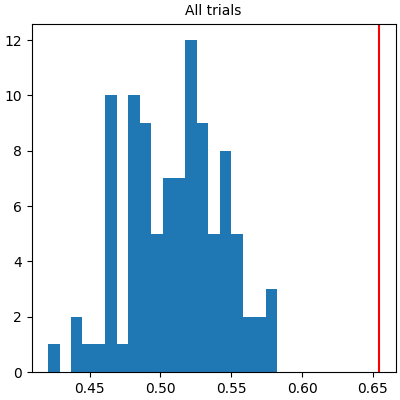

In [37]:
fig, ax = plt.subplots(figsize=(4,4), constrained_layout=True)
ax.hist(rand_mean_rank, bins=20)
ax.axvline(SWDmeanrank, color='r')
ax.set_title('All trials')

Plot the ranked trials

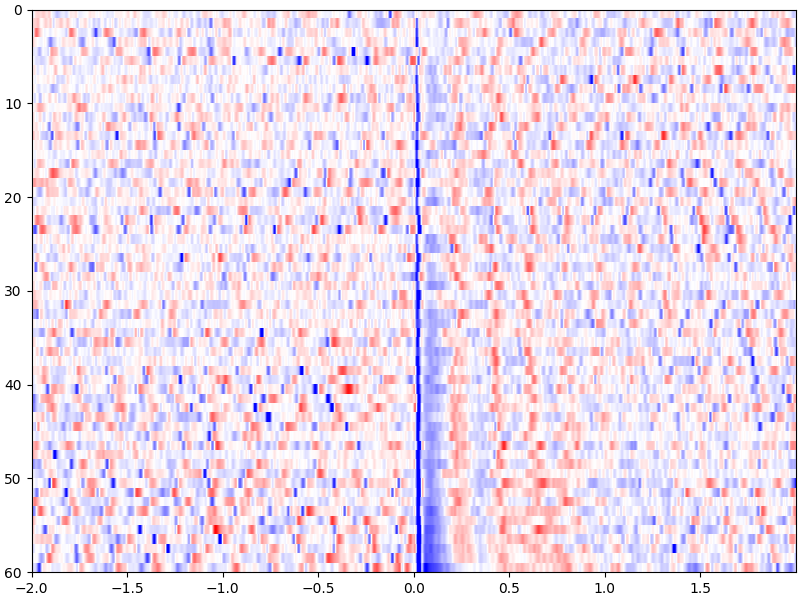

In [42]:
## All trials ##
plot_ch = 10
vlevel = 1.0
ch_ranked = np.argsort(Pw_Response[plot_ch, :])
fig, ax = plt.subplots(figsize=(8,6), constrained_layout=True)
ax.imshow(
    filt_event_EEG[:, plot_ch, ch_ranked].T, aspect='auto', interpolation='none',
    cmap='bwr', vmin=-vlevel, vmax=vlevel, extent=[event_ts[0], event_ts[-1], len(ch_ranked), 0],
)

# Work on looping through all subs to plot all trials

## Loop through all subjects

In [5]:
subject_csv = Path(r"C:\Users\lesliec\OneDrive - Allen Institute\analysis\GAT1-KO_analyses\GAT1_control_NPephys_subjects.csv")
all_subexp = pd.read_csv(subject_csv, converters={'mouse': str})

In [6]:
event_window = [-2.0, 2.0]
check_artifact_trials = False
artifact_check_window = [-0.05, 0.5]
artifact_thresh = 20
BaselineWindow = [-0.5, -0.01]
ResponseWindow = [0.005, 0.1]

645606: EEGNPXspont_estim_2022-12-20_12-26-39
Experiment type: electrical stimulation

644565: EEGNPXspont_estim_2022-12-22_10-36-08
Experiment type: electrical stimulation

672785: EEGNPXspont_estim_2023-07-05_12-39-59
Experiment type: electrical and sensory stimulation

672789: EEGNPXspont_estim_2023-07-13_13-28-01
Experiment type: electrical and sensory stimulation



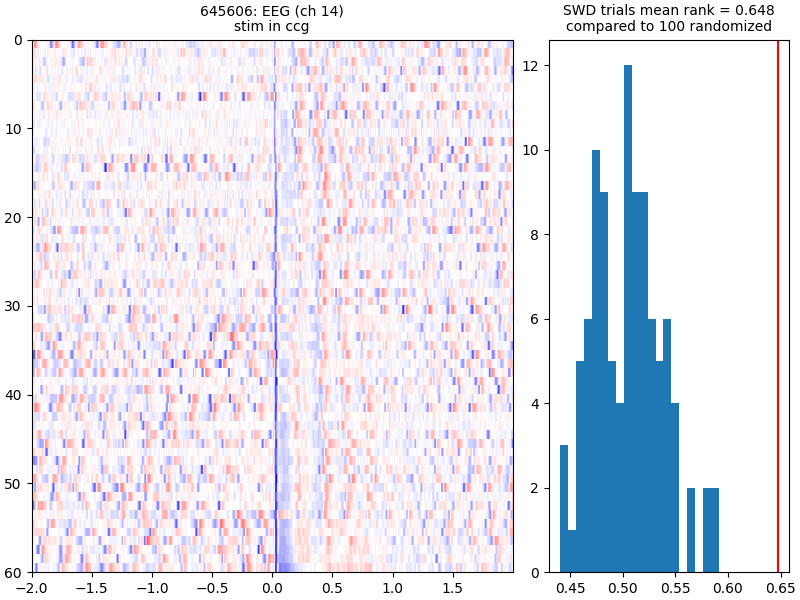

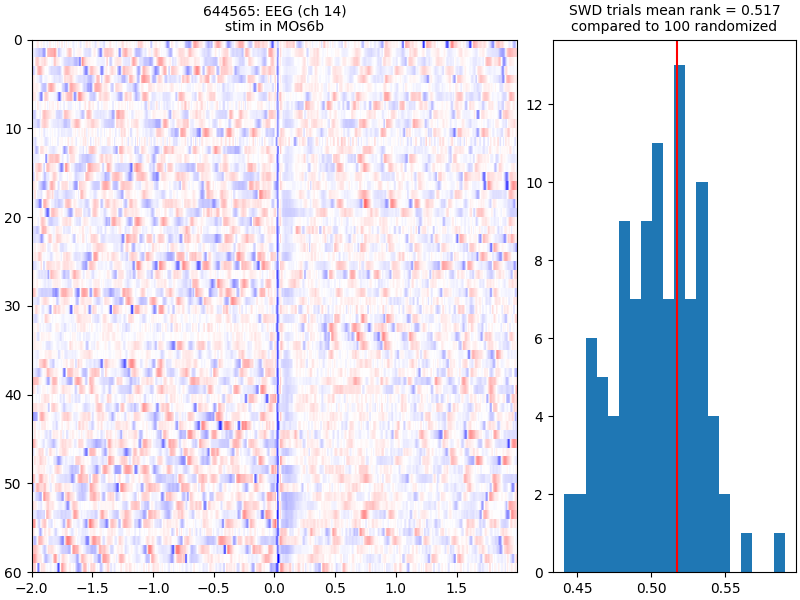

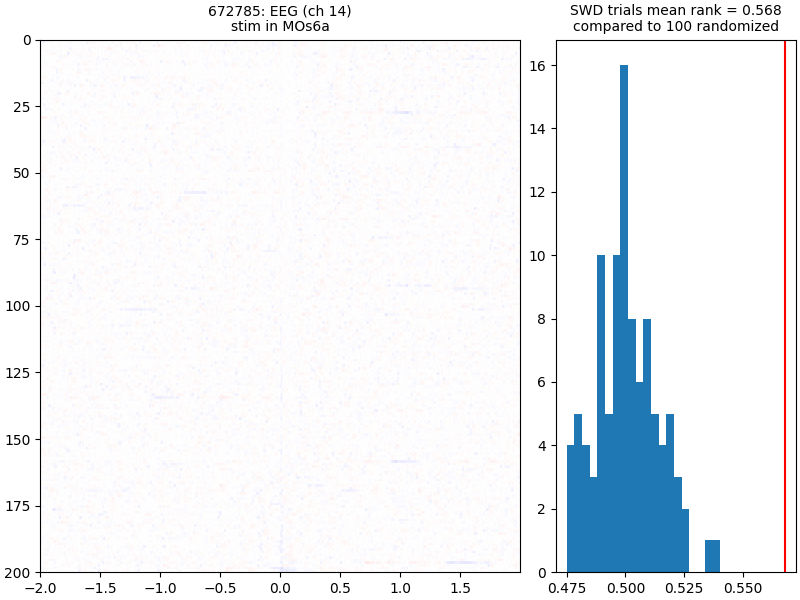

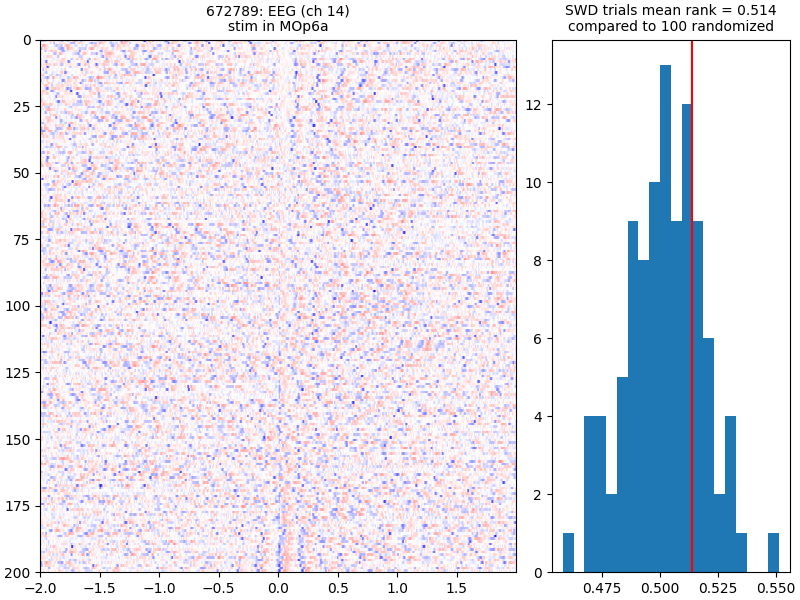

In [10]:
for rowi, exprow in all_subexp[:4].iterrows():
    print('{}: {}'.format(exprow.mouse, exprow.experiment))
    exp = EEGexp(exprow.data_loc, preprocess=False, make_stim_csv=False)
    plotsavedir = os.path.join(r'C:\Users\lesliec\OneDrive - Allen Institute\analysis\GAT1-KO_analyses', 'mouse' + exp.mouse)
    exp_tag = exp.experiment_folder[exp.experiment_folder.find('mouse')+12:exp.experiment_folder.find(str(exp.date.year))-1]
    stim_elec_file = os.path.join(exp.data_folder, r'stim_elec_location.json')
    if os.path.exists(stim_elec_file):
        with open(stim_elec_file) as elec_file:
            stim_elec_data = json.load(elec_file)
    else:
        print('Stim electrode location file not found.')
    stimSWDboolfile = os.path.join(exp.data_folder, r'EP_in_SWD_LFP_TF.npy')
    if os.path.exists(stimSWDboolfile):
        stim_in_SWDtf = np.load(stimSWDboolfile).astype(bool)
        # print(stim_in_SWD[:10])
        # stim_log['manualSWD'] = stim_in_SWD
    else:
        print('Session has no EP_in_SWD file.')

    stim_log = pd.read_csv(exp.stimulus_log_file).astype({'parameter': str})
    # probe_name = sub_LFP_chs[exprow.mouse]

    ## Load EEG data ##
    eeg_data, eeg_ts = exp.load_eegdata()
    eeg_data = eeg_data * 1E-3 # convert to mV
    # eeg_chs = np.arange(0, eeg_data.shape[1])
    # bad_chs = []
    # GOOD_CHS = np.array([x for x in eeg_chs if x not in bad_chs])
    bpb, bpa = signal.butter(3, np.array([0.5, 50])/(exp.ephys_params['EEG']['sample_rate']/2), btype='bandpass')
    filt_data = signal.filtfilt(bpb, bpa, eeg_data, axis=0)

    event_window = [-2.0, 2.0]
    plot_events = stim_log[stim_log['stim_type'] == 'biphasic']
    filt_event_EEG, event_ts = get_evoked_traces(
        filt_data, eeg_ts, plot_events.onset.values, -event_window[0], event_window[1], exp.ephys_params['EEG']['sample_rate']
    )
    
    #### Get artifact trials ####
    if check_artifact_trials:
        event_LFPchs, event_ts = get_evoked_traces(
            lfp_raw_chs, lfp_ts, plot_events.onset.values, -event_window[0], event_window[1], exp.ephys_params[sub_LFP_chs[exprow.mouse]]['lfp_sample_rate']
        )
        checkinds = np.squeeze(np.argwhere((event_ts >= artifact_check_window[0]) & (event_ts <= artifact_check_window[1])))
        num_samples = []
        for chi, max_val in enumerate(np.max(np.max(event_LFPchs[checkinds,:,:], axis=2), axis=0)):
            num_samples.append(np.sum(event_LFPchs[checkinds,chi,:] > (max_val - 500), axis=0))
        num_samples_all_trials = np.array(num_samples)
        good_trials = np.where(np.median(num_samples_all_trials, axis=0) < artifact_thresh)[0]
        bad_trials = np.where(np.median(num_samples_all_trials, axis=0) >= artifact_thresh)[0]
        del event_LFPchs, event_ts

    ## Get mean of abs of signal in baseline and response windows ##
    baselineinds = np.squeeze(np.argwhere((event_ts >= BaselineWindow[0]) & (event_ts <= BaselineWindow[1])))
    responseinds = np.squeeze(np.argwhere((event_ts >= ResponseWindow[0]) & (event_ts <= ResponseWindow[1])))
    Pw_Baseline = np.mean(np.abs(filt_event_EEG[baselineinds, :, :]), axis=0)
    Pw_Response = np.mean(np.abs(filt_event_EEG[responseinds, :, :]), axis=0)

    ## Plot all trials ##
    plot_ch = 14
    vlevel = 1.5
    ch_ranked = np.argsort(Pw_Response[plot_ch, :])
    ## Get mean rank for SWD trials ##
    trial_ranks = np.empty_like(ch_ranked)
    trial_ranks[ch_ranked] = np.arange(len(ch_ranked)) + 1
    rankings = trial_ranks / np.max(trial_ranks)
    SWD_mean_rank = np.mean(rankings[stim_in_SWDtf])
    
    ruff = np.arange(len(ch_ranked)) + 1
    ruff_rankings = ruff / np.max(ruff)
    rand_mean_rank = []
    for i in range(100):
        np.random.shuffle(ruff_rankings)
        rand_mean_rank.append(np.mean(ruff_rankings[stim_in_SWDtf]))
    rand_mean_rank = np.array(rand_mean_rank)
    ## Plot only good trials ##
    fig, axs = plt.subplots(1, 2, figsize=(8,6), gridspec_kw={'width_ratios': [2, 1]}, constrained_layout=True)
    axs[0].imshow(
        filt_event_EEG[:, plot_ch, ch_ranked].T, aspect='auto', interpolation='none',
        cmap='bwr', vmin=-vlevel, vmax=vlevel, extent=[event_ts[0], event_ts[-1], len(ch_ranked), 0],
    )
    axs[0].set_title('{}: EEG (ch {:d})\nstim in {}'.format(exprow.mouse, plot_ch, stim_elec_data['tip']['area']))
    
    axs[1].hist(rand_mean_rank, bins=20)
    axs[1].axvline(SWD_mean_rank, color='r')
    axs[1].set_title('SWD trials mean rank = {:.3f}\ncompared to 100 randomized'.format(SWD_mean_rank))

    ### SAVE ###
    fig_name = '{}{}_EEG-ch{:d}_meanSWDranks.png'.format(exp.mouse, exp_tag, plot_ch)
    fig.savefig(os.path.join(plotsavedir, fig_name), transparent=False)

    print('')